In [40]:
!pip install numpy==1.24.3 


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
# Importing the other functions we may require from Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# To get diferent metric scores
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Code to ignore warnings from function usage
import warnings;
import numpy as np
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit




In [42]:
# Load the dataset
df = pd.read_csv('MSFT.csv')


In [43]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400


In [44]:
df.shape

(9483, 7)

In [45]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9483 entries, 1986-03-13 to 2023-10-26
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9483 non-null   datetime64[ns]
 1   Open       9483 non-null   float64       
 2   High       9483 non-null   float64       
 3   Low        9483 non-null   float64       
 4   Close      9483 non-null   float64       
 5   Adj Close  9483 non-null   float64       
 6   Volume     9483 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 592.7 KB


In [47]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

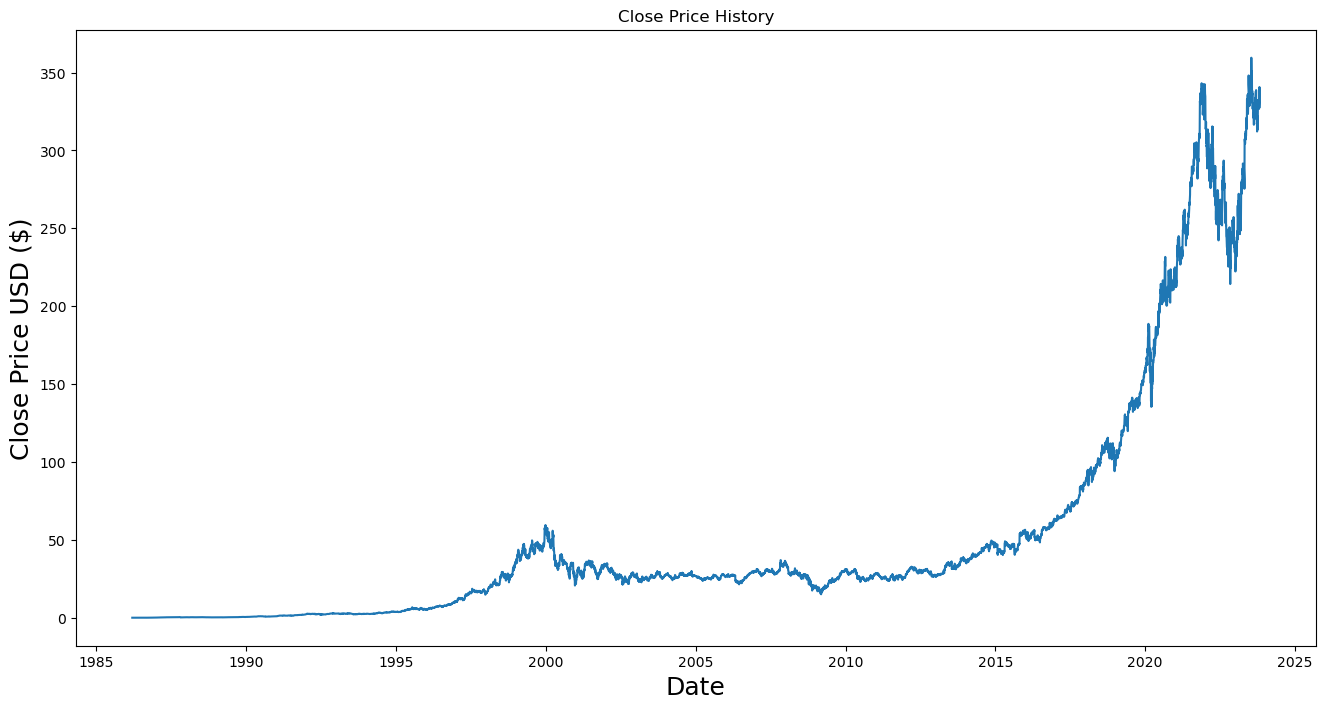

In [48]:
# Visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [49]:
# Focus on the 'Close' column
data = df.filter(['Close'])

In [50]:
# Convert the dataframe to a numpy array
dataset = data.values

In [51]:
# Get the number of rows to train the model on (80% of the dataset)
training_data_len = int(np.ceil(len(dataset) * .8))

In [52]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [53]:
# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

In [54]:
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

In [55]:
# We will use 60 days of price for our training
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [56]:
##Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [57]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)  # Using 1 epoch for quick demonstration, typically use more

7527/7527 [==============================] - 339s 45ms/step - loss: 2.8832e-05


In [60]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]


In [61]:
test_data.shape

(1956, 1)

In [62]:
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]


In [63]:
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [64]:
#Convert the Data to a numpy array and Reshape
x_test = np.array(x_test)

In [65]:
# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [66]:
# Get the Models Predicted Price Values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

60/60 [==============================] - 3s 35ms/step


In [67]:
# Evaluate the Model
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 5.924120177328245


In [68]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

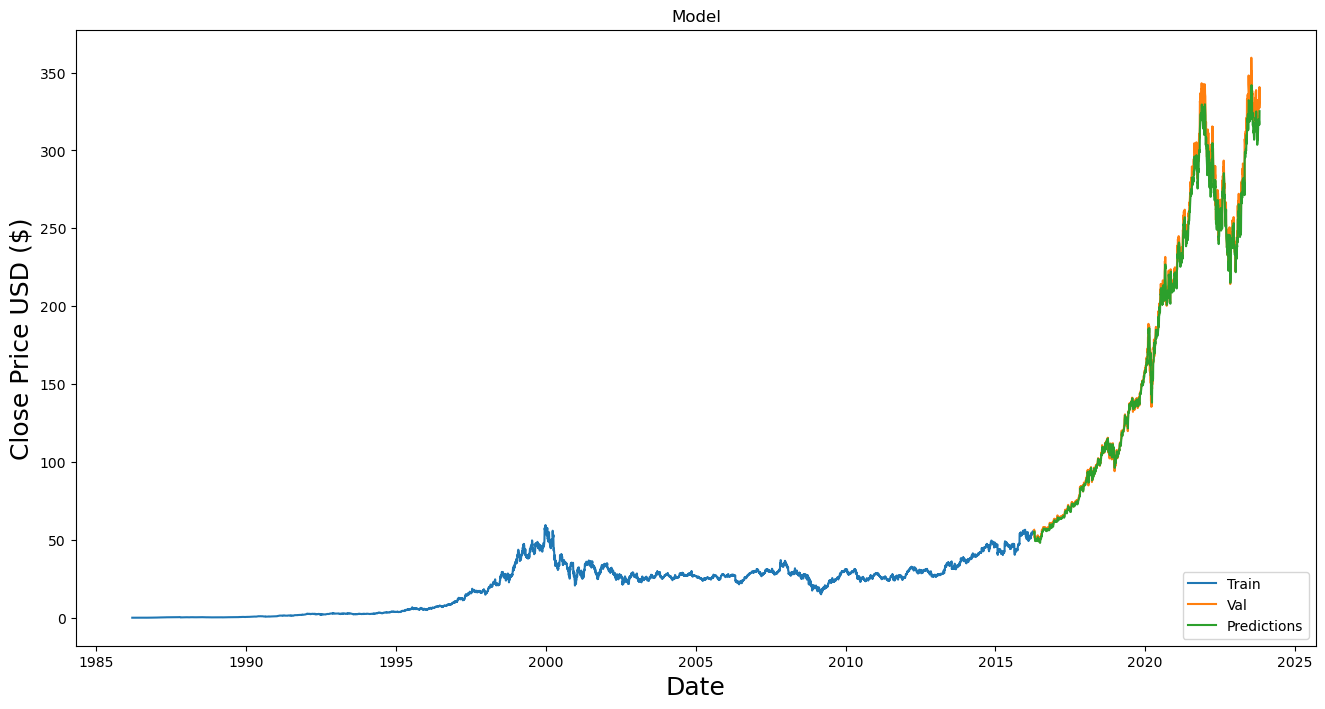

In [69]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Now lets build an Arima model

In [70]:
# Load the dataset
df = pd.read_csv('MSFT.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

In [71]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400


In [72]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Handle missing values
# Here we forward-fill the missing values for simplicity
# You might want to use a more sophisticated method depending on your data
df_numeric = df_numeric.fillna(method='ffill')

# Select the 'Close' column for the time series
ts = df_numeric['Close']


In [73]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(ts.dropna())

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If p-value > 0.05, the series is not stationary
if adf_result[1] > 0.05:
    ts = ts.diff().dropna()


ADF Statistic: 3.102334486044489
p-value: 1.0


In [74]:
p = 1  # example value for the AR(p) model order
d = 1  # example value for differencing
q = 1  # example value for the MA(q) model order

# Assuming 'train' is your training dataset
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


In [75]:
# Split the dataset into train and test sets
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]

# Initialize and fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()


In [76]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

# If the original series was differenced, integrate the predictions
if adf_result[1] > 0.05:
    predictions = predictions.cumsum() + ts[train_size - 1]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse}')


RMSE: 9.464958743450875


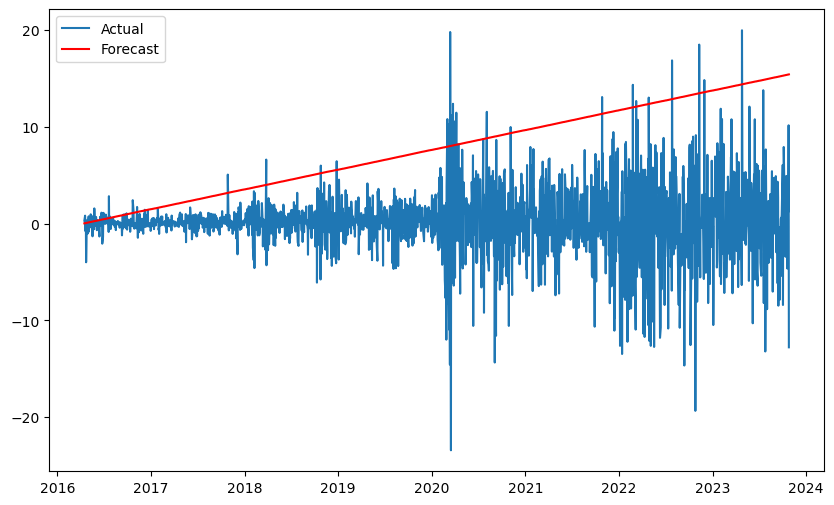

In [77]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Forecast', color='red')
plt.legend()
plt.show()


In [78]:
# Forecast beyond the dataset
future_steps = 5
future_forecast = model_fit.forecast(steps=future_steps)

# If the series was differenced, integrate the predictions
if adf_result[1] > 0.05:
    last_value = ts.iloc[-1]
    future_forecast = future_forecast.cumsum() + last_value

# Print or plot the future forecast
print(future_forecast)


7585   -12.771926
7586   -12.763815
7587   -12.755705
7588   -12.747595
7589   -12.739485
Name: predicted_mean, dtype: float64
